## 「部品基盤のはんだ付け状態」の良品、不良品を判定
##  前処理

In [1]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

from PIL import Image

import os
import glob

%matplotlib inline


Using TensorFlow backend.


## train

In [2]:
# path の設定
test_path = "../data/test/"
train_path ='../data/train/'

In [3]:
# train データの読み込み
train_dir = []
for foldername in os.listdir(train_path):
    imgs_path = train_path + foldername + "/"
    imgs = sorted(glob.glob(imgs_path + "*.jpeg"))
    
    for name in imgs:
        train_dir.append((str(name), str(foldername)))


In [4]:
# データフレームに格納
train_df = pd.DataFrame(train_dir, columns=['Image', 'Label'], index=None)

In [5]:
train_df.head()

,Image,Label
0,../data/train/bridge\bridge_000.jpeg,bridge
1,../data/train/bridge\bridge_001.jpeg,bridge
2,../data/train/bridge\bridge_002.jpeg,bridge
3,../data/train/bridge\bridge_003.jpeg,bridge
4,../data/train/bridge\bridge_004.jpeg,bridge


In [7]:
train_df.shape

(290, 2)

In [8]:
train_df.Label.value_counts()

potato     103
regular    100
horn        57
bridge      30
Name: Label, dtype: int64

In [10]:
# データのレコード数を確認
print("訓練データのレコード数：", len(train_df))

訓練データのレコード数： 290


In [11]:
train_horn = train_df[train_df['Label'] == 'horn']

In [38]:
train_horn[:5]

,Image,Label
30,../data/train/horn\horn_000.jpeg,horn
31,../data/train/horn\horn_001.jpeg,horn
32,../data/train/horn\horn_002.jpeg,horn
33,../data/train/horn\horn_003.jpeg,horn
34,../data/train/horn\horn_004.jpeg,horn


In [40]:
train_horn.shape

(57, 2)

In [39]:
train_bridge = train_df[train_df['Label'] == 'bridge']

In [45]:
train_horn.Image[:1]

30    ../data/train/horn\horn_000.jpeg
Name: Image, dtype: object

In [32]:
img = cv2.imread(train_horn.iloc[0][0])

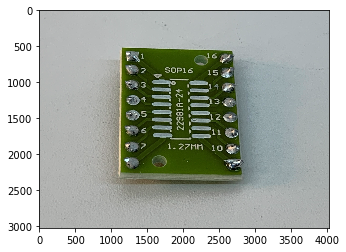

In [33]:
plt.imshow(img)

In [35]:
img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite('../data/create/horn_crt/0.jpeg',img_90)

True

In [49]:
train_horn.iloc[0, 0]

'../data/train/horn\\horn_000.jpeg'

In [50]:
i = 0
for j in range(len(train_horn)):
    img = cv2.imread(train_horn.iloc[j, 0])
    cv2.imwrite('../data/create/horn_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    i += 1
    cv2.imwrite('../data/create/horn_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_180))
    i += 1
    cv2.imwrite('../data/create/horn_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    i += 1
            

In [52]:
i = 0
for j in range(len(train_bridge)):
    img = cv2.imread(train_horn.iloc[j, 0])
    cv2.imwrite('../data/create/bridge_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    i += 1
    cv2.imwrite('../data/create/bridge_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_180))
    i += 1
    cv2.imwrite('../data/create/bridge_crt/{0}.jpeg'.format(i), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    i += 1
            

## train データの各クラスの1件を表示

In [ ]:
# [regular]の画像を表示してみる
# label が "regular" の先頭 5件を表示する
regular_image = train_df[train_df['Label'] == 'regular'].iloc[:5]

In [ ]:
img = image.load_img(regular_image['Image'].iloc[0], target_size=(224, 224))
plt.imshow(img)

In [ ]:
img = cv2.imread(regular_image['Image'].iloc[0], 0)
plt.imshow(img, cmap='binary')

In [ ]:
img.shape

In [ ]:
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.legend(('cdf', 'histgram'), loc='upper left')
plt.show()

In [ ]:
hist.max(), cdf.max() 

In [ ]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min() * 255) / (cdf_m.max() - cdf_m.min())
cdf2 = np.ma.filled(cdf_m, 0).astype('uint8')

In [ ]:
img2 = cdf2[img]

In [ ]:
img = cv2.imread(regular_image['Image'].iloc[0], 0)
equ = cv2.equalizeHist(img)
res = np.hstack((img, equ))
plt.imshow(res, cmap='binary')

In [ ]:
img.shape, equ.shape, res.shape

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl1 = clahe.apply(img)
plt.imshow(cl1, cmap='binary')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

ax = plt.subplot(1, 3, 1)
plt.imshow(img, cmap='binary')
plt.title('original')

ax = plt.subplot(1, 3, 2)
plt.imshow(equ, cmap='binary')
plt.title('equalization')

ax = plt.subplot(1, 3, 3)
plt.imshow(cl1, cmap='binary')
plt.title('CLAHE')


In [ ]:
cl2 = cv2.resize(cl1, (224, 224))

In [ ]:
cl2.shape

In [ ]:
plt.imshow(cl2, cmap='binary')

In [ ]:
cl3 = cl2[25:200, 30:190]
plt.imshow(cl3, cmap='binary')

In [ ]:
plt.imshow(cv2.resize(cl3, (224, 224)), cmap='binary')

In [ ]:
img2 = Image.open(regular_image['Image'].iloc[0])
gray_img = img2.convert('L')
plt.imshow(gray_img, cmap='binary')

In [ ]:
gray_img.size

In [ ]:
gray_resize = gray_img.resize((224, 224))
plt.imshow(gray_resize, cmap='binary')

In [ ]:
gray_resize.size

In [ ]:
im_crop = gray_resize.crop((25, 25, 200, 200))
plt.imshow(im_crop, cmap='bunary')